In [34]:
Method = 'dhl_DB_2025_04_26'
logfile = 'log_'+Method+'.txt'
modelfile = 'model_'+Method+'.pth'
mylog = open(logfile, "a", encoding="utf-8")

In [35]:
#Data prep For Regular Graph
import warnings
warnings.filterwarnings('ignore')
import math
from torch.nn.parameter import Parameter
from torch_geometric.nn import GCNConv, GATConv
from torch.nn import init
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd


class HyperGraphConstructor(nn.Module):
    def __init__(self, num_edges, f_dim, iters=1, eps=1e-8, hidden_dim=128):
        super().__init__()
        self.num_edges = num_edges
        self.edges = None
        self.iters = iters
        self.eps = eps
        self.scale = f_dim ** -0.5
        # self.scale = 1

        self.edges_mu = nn.Parameter(torch.randn(1, f_dim))
        self.edges_logsigma = nn.Parameter(torch.zeros(1, f_dim))
        init.xavier_uniform_(self.edges_logsigma)

        self.to_q = nn.Linear(f_dim, f_dim)
        self.to_k = nn.Linear(f_dim, f_dim)
        self.to_v = nn.Linear(f_dim, f_dim)

        self.gru = nn.GRUCell(f_dim, f_dim)

        hidden_dim = max(f_dim, hidden_dim)

        self.mlp = nn.Sequential(
            nn.Linear(f_dim + f_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, f_dim)
        )

        self.norm_input = nn.LayerNorm(f_dim)
        self.norm_edgs = nn.LayerNorm(f_dim)
        self.norm_pre_ff = nn.LayerNorm(f_dim)

    def mask_attn(self, attn, k):
        indices = torch.topk(attn, k).indices
        mask = torch.zeros(attn.shape).bool().to(attn.device)
        mask.scatter_(1, indices, True)
        return attn.mul(mask)

    def ajust_edges(self, s_level, args):
        if args.stage != 'train':
            return

        # 增加历史记录跟踪
        if not hasattr(self, 's_level_history'):
            self.s_level_history = []
    
        # 更新历史记录，只保存最近的几个记录（这里是5次）
        self.s_level_history.append(s_level)
        if len(self.s_level_history) > 5:
            self.s_level_history.pop(0)

        # 计算平均的饱和度
        avg_s_level = sum(self.s_level_history) / len(self.s_level_history)

        # 动态边调整策略
        # 如果饱和度多次超过上界或者低于下界，才进行调整
        if avg_s_level > args.up_bound:
            # 当饱和度超过上界，增加边数，但速度较慢
            self.num_edges += 1
            print(f"Edges increased to {self.num_edges}. Average saturation: {avg_s_level:.4f}")
        elif avg_s_level < args.low_bound:
            # 当饱和度低于下界，减少边数，速度较慢
            self.num_edges -= 1
            self.num_edges = max(self.num_edges, args.min_num_edges)
            print(f"Edges decreased to {self.num_edges}. Average saturation: {avg_s_level:.4f}")

        # 通过平滑机制，避免边数频繁大幅波动
        # 这里使用了基于指数加权平均的方法，减少边数的波动
        smoothed_s_level = 0.9 * avg_s_level + 0.1 * s_level
        if smoothed_s_level > args.up_bound:
            self.num_edges = int(self.num_edges * 1.1)  # 平滑增加边数，较大变化时适当增速
            print(f"Edges smoothed and increased to {self.num_edges}. Smoothed saturation: {smoothed_s_level:.4f}")
        elif smoothed_s_level < args.low_bound:
            self.num_edges = int(self.num_edges * 0.9)  # 平滑减少边数，较大变化时适当减速
            self.num_edges = max(self.num_edges, args.min_num_edges)
            print(f"Edges smoothed and decreased to {self.num_edges}. Smoothed saturation: {smoothed_s_level:.4f}")
        
        # 打印调整后的边数和饱和度
        mylog.write(f"Adjusted num edges: {self.num_edges}; Smoothed saturation: {smoothed_s_level:.4f}\n")
        mylog.flush()

    def forward(self, inputs, args):
        n, d, device = *inputs.shape, inputs.device
        n_s = self.num_edges
        
        mu = self.edges_mu.expand(n_s, -1)
        sigma = self.edges_logsigma.exp().expand(n_s, -1)
        edges = mu + sigma * torch.randn(mu.shape, device = device)

        inputs = self.norm_input(inputs)        
        k, v = self.to_k(inputs), self.to_v(inputs)
        k = F.relu(k)
        v = F.relu(v)

        for _ in range(self.iters):

            edges = self.norm_edgs(edges)

            q = self.to_q(edges)
            q = F.relu(q)

            dots = torch.einsum('ni,ij->nj', q, k.T) * self.scale
            attn = dots.softmax(dim=1) + self.eps
            attn = attn / attn.sum(dim=1, keepdim=True)
            attn = self.mask_attn(attn,args.k_n)        

            updates = torch.einsum('in,nf->if', attn, v)
            edges = torch.cat((edges,updates),dim=1)
            edges = self.mlp(edges)

            q = self.to_q(inputs)
            k = self.to_k(edges)
            k = F.relu(k)
            q = F.relu(q)

            dots = torch.einsum('ni,ij->nj', q, k.T) * self.scale
            attn_v = dots.softmax(dim=1)
            attn_v = self.mask_attn(attn_v,args.k_e)    
            H = attn_v
            
            cc = H.ceil().abs()
            de = cc.sum(dim=0)
            empty = (de == 0).sum()
            s_level = 1 - empty/n_s

            self.ajust_edges(s_level, args)

            print("Num edges is: {}; Satuation level is: {}".format(self.num_edges, s_level))
            mylog.write("Num edges is: {}; Satuation level is: {}\n".format(self.num_edges, s_level))
            mylog.flush()
        self.edges = edges

        return edges, H, dots


class DDHCNN_conv(nn.Module):
    def __init__(self, in_ft, out_ft, num_edges, bias=True):
        super(DDHCNN_conv, self).__init__()

        self.HyperGraphConstructor = HyperGraphConstructor(num_edges, in_ft)

        self.weight = Parameter(torch.Tensor(in_ft, out_ft))
        if bias:
            self.bias = Parameter(torch.Tensor(out_ft))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

        self.mlp = nn.ModuleList()
        self.mlp.append(nn.Linear(in_ft, out_ft))
        self.mlp.append(nn.Linear(out_ft, out_ft))

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x, args):
        edges, H, H_raw = self.HyperGraphConstructor(x, args)
        edges = edges.matmul(self.weight)
        if self.bias is not None:
            edges = edges + self.bias
        nodes = H.matmul(edges)
        # x = self.mlp[0](x) + self.mlp[1](nodes)
        x = x + nodes
        return x, H, H_raw


class DDHCNN_classifier(nn.Module):
    def __init__(self, args, dropout=0.5):
        super(DDHCNN_classifier, self).__init__()
        in_dim = args.in_dim
        hid_dim = args.hid_dim
        out_dim = args.out_dim
        num_edges = args.num_edges
        self.conv_number = args.conv_number

        self.dropout = dropout

        self.linear_backbone = nn.ModuleList()
        self.linear_backbone.append(nn.Linear(in_dim, hid_dim))
        self.linear_backbone.append(nn.Linear(hid_dim, hid_dim))
        self.linear_backbone.append(nn.Linear(hid_dim, hid_dim))

        self.gcn_backbone = nn.ModuleList()
        self.gcn_backbone.append(GCNConv(in_dim, hid_dim))
        self.gcn_backbone.append(GCNConv(hid_dim, hid_dim))

        self.convs = nn.ModuleList()
        self.transfers = nn.ModuleList()

        for i in range(self.conv_number):
            self.convs.append(DDHCNN_conv(hid_dim, hid_dim, num_edges))
            self.transfers.append(nn.Linear(hid_dim, hid_dim))

        self.classifier = nn.Sequential(
            nn.Linear(self.conv_number * hid_dim, out_dim),
        )

    def forward(self, data, args):

        if args.backbone == 'linear':
            x = data['fts']
            #x = self.linear_backbone[0](x)
            x = F.relu(self.linear_backbone[0](x))
            x = F.relu(self.linear_backbone[1](x))
            x = self.linear_backbone[2](x)
        elif args.backbone == 'gcn':
            x = data['fts']
            edge_index = data['edge_index']
            x = self.gcn_backbone[0](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
            x = self.gcn_backbone[1](x, edge_index)

        tmp = []
        H = []
        H_raw = []
        for i in range(self.conv_number):
            x, h, h_raw = self.convs[i](x, args)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
            if args.transfer == 1:
                x = self.transfers[i](x)
                x = F.relu(x)
            tmp.append(x)
            H.append(h)
            H_raw.append(h_raw)

        x = torch.cat(tmp, dim=1)

        out = self.classifier(x)
        return out, x, H, H_raw


class GCN(nn.Module):
    def __init__(self, args, layer_number=2):

        in_dim = args.in_dim
        hid_dim = args.hid_dim
        out_dim = args.out_dim

        super(GCN, self).__init__()
        # graph convolution
        self.convs = nn.ModuleList()

        self.convs.append(GCNConv(in_dim, hid_dim))
        for i in range(1, layer_number):
            self.convs.append(GCNConv(hid_dim, hid_dim))

        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(hid_dim, out_dim),
        )

    def forward(self, data, args):
        x = data['fts']
        edge_index = data['edge_index']

        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)

        out = self.classifier(x)
        return out, x, None, None


class GAT(nn.Module):
    def __init__(self, args, layer_number=2):
        super(GAT, self).__init__()

        in_dim = args.in_dim
        hid_dim = args.hid_dim
        out_dim = args.out_dim

        # graph convolution
        self.convs = nn.ModuleList()

        self.convs.append(GATConv(in_dim, hid_dim))
        for i in range(1, layer_number):
            self.convs.append(GATConv(hid_dim, hid_dim))

        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(hid_dim, out_dim),
        )

    def forward(self, data, args):
        x = data['fts']
        edge_index = data['edge_index']

        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)

        out = self.classifier(x)
        return out, x, None, None


In [36]:

import time
import datetime


def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))


def contrast_loss(H_raw, mask, labels):  #拥有相同lbl的结点应该属于相同的边
    lbl_num = labels.max().item() + 1
    total_loss = 0
    for h in H_raw:
        for lbl in range(lbl_num):
            lbl_mask = labels == lbl
            src = h[mask][lbl_mask]
            target_idx = [i for i in range(src.shape[0])]
            random.shuffle(target_idx)
            target = src[target_idx]
            loss = F.mse_loss(src, target)
            total_loss = total_loss + loss
    return total_loss


def contrast_loss2(H, x):  #相同边的结点特征应该相似
    total_loss = 0
    feartures = x
    for h in H:
        cc = h.ceil().abs()
        for i in range(cc.shape[1]):  #h 是 n*n 维
            col_mask = cc[:, i] == 1
            src = feartures[col_mask]  #属于同一条边的结点
            target_idx = [i for i in range(src.shape[0])]
            random.shuffle(target_idx)
            target = src[target_idx]  #随机调换idx
            loss = F.mse_loss(src, target) + 1e-8  #同一条边的结点特征应该相似
            if loss > 1e-8:
                total_loss = total_loss + loss
    return total_loss



def train(model, optimizer, data, args):
    device = torch.device(args.device)
    model.to(device)
    train_mask = data['train_idx']
    labels = data['lbls'][train_mask]

    best_acc = 0
    patience = 0
    best_epoch = 0

    spent_time = []

    for epoch in range(args.epoch):
        t0 = time.time()

        model.train()
        optimizer.zero_grad()

        args.stage = 'train'
        out, x, H, H_raw = model(data, args)

        pred = F.log_softmax(out, dim=1)

        contra_ls = 0
        contra_ls2 = 0
        if H_raw is not None:

            contra_ls = contrast_loss(H_raw, train_mask, labels)
            contra_ls2 = contrast_loss2(H, x)

        loss = F.nll_loss(pred[train_mask], labels) + contra_ls * args.namuda + contra_ls2 * (args.namuda2 / 1000)

        loss.backward()
        optimizer.step()

        _, pred = pred[train_mask].max(dim=1)
        correct = int(pred.eq(labels).sum().item())
        acc = correct / len(labels)
        args.stage = 'test'
        test_acc, test_loss = evaluate(model, data, args)
        
        if test_acc > best_acc:
            patience = 0
            best_acc = test_acc
            best_epoch = epoch
            torch.save(model.state_dict(), modelfile)
            if H is not None:
                args.num_edges = H[0].shape[1]
        else:
            patience = patience + 1

        if patience > args.patience:
            break

        print("========================> ", epoch)
        mylog.write(str("========================> " + str(epoch)+"\n"))
    
        print("Train acc: {}, loss: {}".format(acc, loss))
        mylog.write("Train acc: {}, loss: {}\n".format(acc, loss))
        # print("Val acc: {}, loss: {}".format(val_acc,val_loss))
        print("Test acc: {}, loss: {}".format(test_acc, test_loss))

        mylog.write("Test acc: {}, loss: {}\n".format(test_acc, test_loss))
        # print("Epoch: {}; Loss: {}, acc: {}".format(i,loss,acc))
        print("Time: {} (h:mm:ss)".format(format_time(time.time() - t0)))
        mylog.write("Time: {} (h:mm:ss)\n".format(format_time(time.time() - t0)))
        spent_time.append(format_time(time.time() - t0))
        mylog.flush()

    print("Best epch: {}, acc: {}".format(best_epoch, best_acc))
    mylog.write("Best epch: {}, acc: {}\n".format(best_epoch, best_acc))
    mylog.flush()
    return best_acc


def evaluate(model, data, args):
    stage = args.stage
    model.eval()
    mask = data['test_idx']
    labels = data['lbls'][mask]
    out, x, H, H_raw = model(data, args)
    pred = F.log_softmax(out, dim=1)

    contra_ls = 0
    contra_ls2 = 0
    if H_raw is not None:
        contra_ls = contrast_loss(H_raw, mask, labels)
        contra_ls2 = contrast_loss2(H, x)
    loss = F.nll_loss(pred[mask], labels) + contra_ls * args.namuda + contra_ls2 * (args.namuda2 / 1000)
    _, pred = pred[mask].max(dim=1)
    correct = int(pred.eq(labels).sum().item())
    acc = correct / len(labels)
    return acc, loss


def train_dhl(data, args):
    in_dim = args.in_dim
    hid_dim = args.hid_dim
    out_dim = args.out_dim
    num_edges = args.num_edges
    model = DDHCNN_classifier(args)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lrate, weight_decay=args.wdecay)
    best_acc = train(model, optimizer, data, args)

    return best_acc


# def train_gcn(data, args):
#     in_dim = args.in_dim
#     hid_dim = args.hid_dim
#     out_dim = args.out_dim
#     model = GCN(args)
#     optimizer = torch.optim.Adam(model.parameters(), lr=args.lrate, weight_decay=args.wdecay)
# 
#     best_acc = train(model, optimizer, data, args)
# 
#     return best_acc
# 
# 
# def train_gat(data, args):
#     model = GAT(args)
#     optimizer = torch.optim.Adam(model.parameters(), lr=args.lrate, weight_decay=args.wdecay)
# 
#     best_acc = train(model, optimizer, data, args)
# 
#     return best_acc


In [37]:
import random
import argparse
from sklearn.manifold import TSNE
from sklearn import metrics
from matplotlib import rcParams


def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def arg_parse():
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataset', type=str, default='DDI', help='40/NTU/DDI')
    parser.add_argument('--f_dim', type=int, default=64)
    parser.add_argument('--seed', type=int, default=777)
    parser.add_argument('--lrate', type=float, default=0.001)
    parser.add_argument('--wdecay', type=float, default=0.00)

    parser.add_argument('--in_dim', type=int, default=128)
    parser.add_argument('--out_dim', type=int, default=2)
    parser.add_argument('--hid_dim', type=int, default=128)
    parser.add_argument('--num_edges', type=int, default=100)
    parser.add_argument('--min_num_edges', type=int, default=64)

    parser.add_argument('--k', type=int, default=5)
    parser.add_argument('--cuda', type=str, default='0', help='0/1/2/3')
    parser.add_argument('--drop_rate', type=float, default=0.2)
    parser.add_argument('--patience', type=int, default=200)
    parser.add_argument('--epoch', type=int, default=1500)
    parser.add_argument('--device', type=str, default='cpu')
    parser.add_argument('--model', type=str, default='dhl')

    parser.add_argument('--edges', type=str, default='h')
    parser.add_argument('--mask', type=int, default=1)
    parser.add_argument('--cf', type=str, default='x')
    parser.add_argument('--merge', type=str, default='cat', help='cat/plus')
    parser.add_argument('--stage', type=str, default='train', help='train/val')

    parser.add_argument('--conv_number', type=int, default=1)
    parser.add_argument('--k_n', type=int, default=10, help='number of nodes to choose')
    parser.add_argument('--k_e', type=int, default=10, help='number of edges to choose')

    parser.add_argument('--low_bound', type=float, default=0.9)
    parser.add_argument('--up_bound', type=float, default=0.95)

    parser.add_argument('--backbone', type=str, default='linear')
    parser.add_argument('--namuda', type=int, default=30)
    parser.add_argument('--namuda2', type=float, default=10)

    parser.add_argument('--splits', type=int, default=1)

    parser.add_argument('--split_ratio', type=float, default=0.8)

    parser.add_argument('--transfer', type=int, default=1)

    args = parser.parse_args(args=[])

    args.device = 'cuda:{}'.format(args.cuda) if torch.cuda.is_available() else 'cpu'

    return args




def plot_embedding_2d(X, labels, fname, title=None):
    config = {
        "font.size": 20,
        "mathtext.fontset": 'stix'
    }

    rcParams.update(config)

    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # Plot colors numbers
    num_of_labels = labels.max().item() + 1

    # fig = plt.figure(figsize=(16,10))

    plt.figure(figsize=(16, 10))

    # plt.margins(0.001)

    colors_space = np.linspace(0, 1, num_of_labels)  # 生成颜色空间
    label_to_color = {}  # 将标签对应为颜色
    for i in range(num_of_labels):
        label_to_color[i] = colors_space[i]

    colors = []
    for label in labels:
        colors.append(label_to_color[label.item()])

    sc = plt.scatter(X[:, 0], X[:, 1], c=colors, s=20)
    # scatter = mscatter(X[:, 0], X[:, 1], c='r', ax=ax)

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

    cb = plt.colorbar(sc)
    cb.ax.tick_params(labelsize=32)  #设置色标刻度字体大小。

    plt.tight_layout(rect=(0, 0, 1.06, 1))

    plt.savefig(f'./{fname}.eps')
    plt.savefig(f'./{fname}.png')
    # plt.show()

def draw_TSNE(X, labels, fname, title=None):
    tsne2d = TSNE(n_components=2, init='pca', random_state=0)
    X_tsne_2d = tsne2d.fit_transform(X)
    plot_embedding_2d(X_tsne_2d, labels, fname, title)


def visualization(model, data, args, title=None):
    mask = data['train_idx']

    out, x, H, H_raw = model(data, args)

    X = x[mask].detach().to('cpu')
    labels = data['lbls'][mask].detach().to('cpu')
    args.fts = '1'
    fname = f'{args.model}_{args.dataset}_{args.fts}'
    draw_TSNE(X, labels, fname, title=None)
    Silhouette_score = metrics.silhouette_score(X, labels)
    print("Silhouette_score is: ", Silhouette_score)

In [38]:
args = arg_parse()
setup_seed(args.seed)
device = torch.device(args.device)
df_re = pd.read_csv('data/DrugBank_1706.csv')
df_re = df_re.sample(frac=1).reset_index(drop=True)
df_re = df_re.iloc[:int(len(df_re))]
lbls = df_re.label.astype(np.longlong)
yasuo_ratio = 2
fts = df_re[['Drug1_SMILES', 'Drug2_SMILES']].values

In [39]:
import rdkit
import numpy as np
from matplotlib import pyplot as plt

print("RDKit: %s" % rdkit.__version__)
fts0 = fts[:,0]
fts1 = fts[:,1]
fts0

RDKit: 2020.09.1


array(['NC(=O)N1C2=CC=CC=C2C=CC2=CC=CC=C12',
       'CN(C)CCC(C1=CC=C(Br)C=C1)C1=CC=CC=N1',
       'CN(C)CCC=C1C2=CC=CC=C2C=CC2=CC=CC=C12', ...,
       '[H][C@@]12C(=O)CC[C@]11CC[C@@H](C)[C@@]2(C)[C@@H](C[C@@](C)(C=C)[C@@H](O)[C@@H]1C)OC(=O)CS[C@H]1C[C@@H]2CC[C@H](C1)N2C',
       'CCCOC(C(=O)OC1CCN(C)CC1)(C1=CC=CC=C1)C1=CC=CC=C1',
       'CC1=CC=C(C=C1)C1=CC(=NN1C1=CC=C(C=C1)S(N)(=O)=O)C(F)(F)F'],
      dtype=object)

In [40]:
print("pytorch版本：", torch.__version__) 
print("是否可用：", torch.cuda.is_available())        # 查看GPU是否可用
print("GPU数量：", torch.cuda.device_count())        # 查看GPU数量
print("torch方法查看CUDA版本：", torch.version.cuda)  # torch方法查看CUDA版本
print("GPU索引号：", torch.cuda.current_device())    # 查看GPU索引号
print("GPU名称：", torch.cuda.get_device_name(torch.cuda.current_device()))    # 根据索引号得到GPU名称

pytorch版本： 1.13.1+cu117
是否可用： True
GPU数量： 1
torch方法查看CUDA版本： 11.7
GPU索引号： 0
GPU名称： NVIDIA GeForce RTX 3080


In [41]:
from rdkit import Chem
from rdkit.Chem import AllChem
errorMol = []
map = {}
# numba.njit(target="cuda")
def smiles_to_vector(smiles_strings):
    one_hot = np.zeros((smiles_strings.shape[0], 2048), dtype=np.int8)
    for i in range(smiles_strings.shape[0]):
        if smiles_strings[i] in map:
            one_hot[i] = map[smiles_strings[i]]
            continue
        molecule = Chem.MolFromSmiles(smiles_strings[i])
        if molecule is None:
            errorMol.append(smiles_strings[i])
            print(smiles_strings[i])
            continue
        # Generate a fingerprint for the molecule
        # GetMorganGenerator()
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=2048)
        arr = np.array(fingerprint)
        map[smiles_strings[i]] = arr
        one_hot[i] = arr
    # Convert the fingerprint to a numpy array and return it
    return one_hot
# Test the function with a SMILES string

In [42]:
t = time.time()
X_train = smiles_to_vector(fts0)
X1_train = smiles_to_vector(fts1)
print(time.time()-t)
print(X_train.shape)
print(X1_train.shape)

3.2522172927856445
(765608, 2048)
(765608, 2048)


In [43]:
import numba
from numba import jit

In [44]:
numba.njit(target="cuda")
def tensor_merging(X_train,X1_train):
    X_TOTAL_T1 = np.zeros((X_train.shape[0],int(X_train.shape[1])))
    for i in range(int(X_TOTAL_T1.shape[0])):
        for j in range(int(X_TOTAL_T1.shape[1])):
            X_TOTAL_T1[i,j] += (X_train[i,j]+X1_train[i,j])/2
    return X_TOTAL_T1

tensor_merging_fun = jit(parallel=True)(tensor_merging)
X_TOTAL = tensor_merging_fun(X_train,X1_train)

In [13]:
numba.njit(target="cuda")
def tensor_slicing(X_train,X1_train):
    X_TOTAL_T1 = np.zeros((X_train.shape[0],int(X_train.shape[1])))
    for i in range(int(X_TOTAL_T1.shape[0])):
        for j in range(int(X_TOTAL_T1.shape[1])):
            X_TOTAL_T1[i,int(j/2)] += X_train[i,j]/2
            X_TOTAL_T1[i,int((j+X1_train.shape[1])/2)] +=X1_train[i,j]/2
    return X_TOTAL_T1
tensor_slicing_fun = jit(parallel=True)(tensor_slicing)
X_TOTAL = tensor_slicing_fun(X_train,X1_train)

In [45]:
compress=1

In [46]:
numba.njit(target="cuda")
def tensor_yasuo(X_TOTAL):
    X_TOTAL_T1 = np.zeros((X_TOTAL.shape[0],int(X_TOTAL.shape[1]/compress)))
    for i in range(int(X_TOTAL.shape[0])):
        for j in range(int(X_TOTAL.shape[1])):
            X_TOTAL_T1[i,int(j/compress)] += (X_TOTAL[i,j])/compress
    return X_TOTAL_T1

tensor_yasuo_fun = jit(parallel=True)(tensor_yasuo)
X_TOTAL = tensor_yasuo_fun(X_TOTAL)

In [47]:
new_temp = pd.DataFrame(X_TOTAL)
new_temp.loc[:,'label']=lbls
df_shuffled = new_temp
X_train = None
X1_train = None
X_TOTAL = None
lbls_train = df_shuffled.label.astype(np.longlong)
fts_train = df_shuffled.drop('label',axis=1).values


In [49]:
fts_train = fts_train.astype(np.float16)

In [50]:
idx_list = [i for i in range(fts_train.shape[0])]
train_idx = random.sample(idx_list, int(fts_train.shape[0]*0.8))
test_idx = []
train_idx = np.sort(train_idx)
i = 0
j = 0
while(i < len(idx_list)):
    if j < len(train_idx) and i == train_idx[j]:
        j = j + 1
        i = i + 1
        continue
    test_idx.append(i)
    i = i + 1
    if i % 5000 == 0:
        print(i)
np.random.shuffle(train_idx)
np.random.shuffle(test_idx)

65000
85000
105000
170000
185000
210000
215000
220000
225000
275000
280000
295000
300000
305000
330000
335000
340000
385000
405000
410000
420000
425000
490000
545000
600000
605000
670000
730000
740000
745000
755000
765000


In [51]:
train_idx = torch.Tensor(train_idx).long().to(device)
test_idx = torch.Tensor(test_idx).long().to(device)
fts_train = torch.Tensor(fts_train).to(device)
lbls_train = torch.Tensor(lbls_train).squeeze().long().to(device)
data = {
    'fts': fts_train,
    'lbls': lbls_train,
    'train_idx': train_idx,
    'test_idx': test_idx
}
lbls = data['lbls']

In [57]:
args.in_dim = data['fts'].shape[1]
args.out_dim = int(lbls.max().item() + 1)
args.min_num_edges = args.k_e
args_list = []
args.num_edges = 30
args.patience = 100
args.epoch = 3000
n, d, device = *data['fts'].shape, data['fts'].device
data['fts'].shape

torch.Size([765608, 2048])

In [48]:
best_acc = train_dhl(data, args)

args.best_acc = best_acc
args_list.append(args.__dict__)
best_acc

Edges decreased to 16. Average saturation: 0.7647
Edges smoothed and decreased to 14. Smoothed saturation: 0.7647
Num edges is: 14; Satuation level is: 0.7647058963775635
Num edges is: 14; Satuation level is: 0.8571428656578064
========================>  0
Train acc: 0.49984491391491437, loss: 0.6956884860992432
Test acc: 0.5006203351779279, loss: 0.693595290184021
Time: 0:00:03 (h:mm:ss)
Edges decreased to 13. Average saturation: 0.7395
Edges smoothed and decreased to 11. Smoothed saturation: 0.7370
Num edges is: 11; Satuation level is: 0.7142857313156128
Num edges is: 11; Satuation level is: 1.0
========================>  1
Train acc: 0.5025970765042119, loss: 0.6937705278396606
Test acc: 0.49937966482207213, loss: 0.6932005286216736
Time: 0:00:04 (h:mm:ss)
Edges decreased to 10. Average saturation: 0.8263
Edges smoothed and decreased to 10. Smoothed saturation: 0.8437
Num edges is: 10; Satuation level is: 1.0
Num edges is: 10; Satuation level is: 1.0
========================>  2
Tra

0.9522440378896788

In [33]:
args_list = []
# args.best_acc = '0.9288879261111876'
args.stage = 'test'
args_list.append(args.__dict__)
args_list

[{'dataset': 'DDI',
  'f_dim': 64,
  'seed': 777,
  'lrate': 0.001,
  'wdecay': 0.0,
  'in_dim': 2048,
  'out_dim': 2,
  'hid_dim': 128,
  'num_edges': 30,
  'min_num_edges': 10,
  'k': 5,
  'cuda': '0',
  'drop_rate': 0.2,
  'patience': 20,
  'epoch': 1500,
  'device': 'cuda:0',
  'model': 'dhl',
  'edges': 'h',
  'mask': 1,
  'cf': 'x',
  'merge': 'cat',
  'stage': 'test',
  'conv_number': 1,
  'k_n': 10,
  'k_e': 10,
  'low_bound': 0.9,
  'up_bound': 0.95,
  'backbone': 'linear',
  'namuda': 30,
  'namuda2': 10,
  'splits': 1,
  'split_ratio': 0.8,
  'transfer': 1,
  'best_acc': 0.65}]

In [55]:
# args.num_edges = 14
model = DDHCNN_classifier(args)
state_dict = torch.load(modelfile,map_location=args.device)
model.load_state_dict(state_dict)
model.to(args.device)


Starting TorchExplorer at http://localhost:8080


C:\Users\Admin\AppData\Local\Temp\ipykernel_25868\3843800710.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(modelfile,map_location=args.device)


HGNN_classifier(
  (linear_backbone): ModuleList(
    (0): Linear(in_features=2048, out_features=128, bias=True)
    (1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
  )
  (gcn_backbone): ModuleList(
    (0): GCNConv(2048, 128)
    (1): GCNConv(128, 128)
  )
  (convs): ModuleList(
    (0): HGNN_conv(
      (HConstructor): HConstructorTransformer(
        (to_q): Linear(in_features=128, out_features=128, bias=True)
        (to_k): Linear(in_features=128, out_features=128, bias=True)
        (to_v): Linear(in_features=128, out_features=128, bias=True)
        (gru): GRUCell(128, 128)
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=128, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=128, out_features=128, bias=True)
        )
        (norm_input): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm_edgs): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm_pre_ff): LayerNorm((128,

In [ ]:
args.num_edges = 15

In [56]:
model.eval()
mask = data['test_idx']
labels = data['lbls'][mask]

In [57]:
data['fts'] = torch.Tensor(fts_train).to(device)
data['lbls'] = torch.Tensor(lbls_train).to(device)

In [58]:
data['fts'].shape

torch.Size([100, 2048])

In [59]:
out, x, H, H_raw = model(data,args)
pred = F.softmax(out, dim=1)
pred_numpy=pred[mask].cpu().detach().numpy()
a, pred = pred[mask].max(dim=1)
ac = a.cpu().detach().numpy()
scores = pred_numpy[:,1]

Num edges is: 30; Satuation level is: 0.46666663885116577


In [37]:
from sklearn.metrics import precision_recall_curve,auc,roc_auc_score

In [38]:
def compute_auc(_scores, _labels):
    precision, recall, thresholds = precision_recall_curve(_labels, _scores)
    auc_precision_recall = auc(recall, precision)
    return roc_auc_score(_labels, _scores),auc(recall, precision)
labels_cpu = labels.cpu().numpy()
scores_cpu = scores
t = compute_auc(_scores=scores_cpu,_labels=labels_cpu)
t

(np.float64(0.9603841536614646), np.float64(0.955242445424498))

In [43]:
pred1 = pred.cpu().numpy()
labels1 = labels.cpu().numpy()
tp = 0
fp = 0
tn = 0
fn = 0
acc = 0
for i in range(len(pred1)):
    if pred1[i] == labels1[i]:
        if pred[i] == 1:
            tp+=1
        else :
            tn+=1
        acc+=1
    else:
        if pred[i] == 1:
            fp+=1
        else:
            fn+=1
            
print(sum)
p = tp/(tp+fp)
r = tp/(tp+fn)
f1 = 2*p*r/(p+r)
print('Accuracy: {:.6f}, Precision: {:.6f}, Recall: {:.6f}, F1-score {:.6f}, ROC-AUC {:.6f}, PR-AUC {:.6f}'.format( acc/len(pred),p, r, f1,t[0],t[1]))

<built-in function sum>
Accuracy: 0.910000, Precision: 0.925532, Recall: 0.887755, F1-score 0.906250, ROC-AUC 0.960384, PR-AUC 0.955242


Num edges is: 31; Satuation level is: 0.9677419662475586
Silhouette_score is:  0.8876096


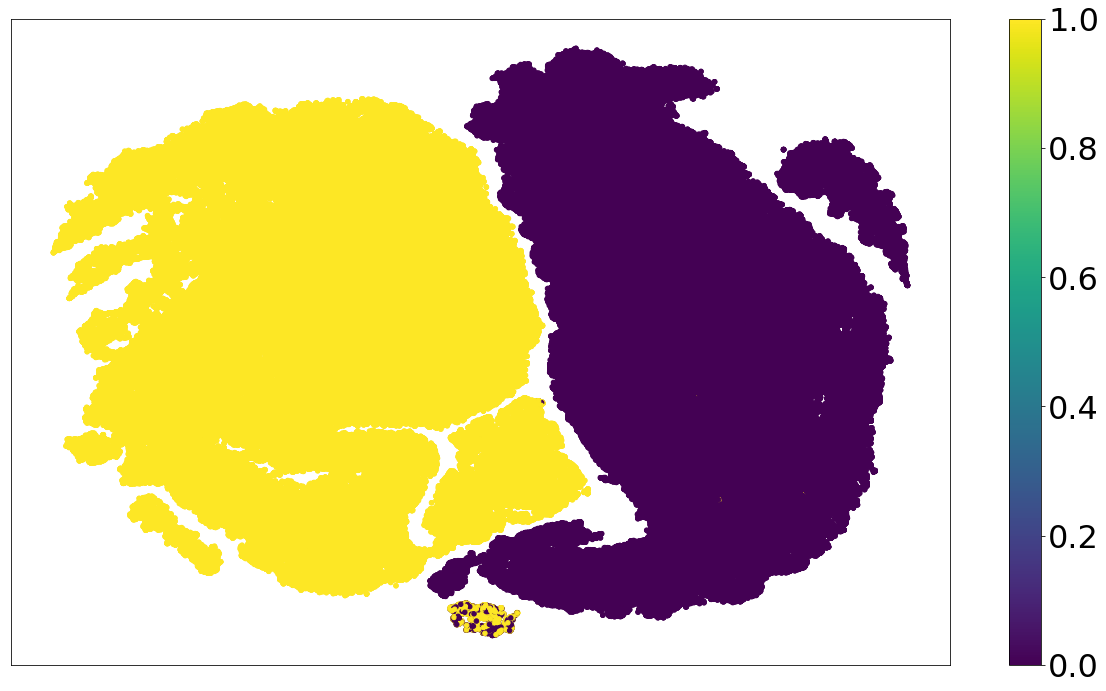

In [41]:
visualization(model, data, args, title=None)